In [11]:
#%load_ext autoreload
#%autoreload 2

In [1]:
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("/Users/lucreziavaleriani/Desktop/PDO61_chr1820.csv", sep = ',') 
data['original_baf'] = data['median_baf']
data['median_baf'] = data['median_baf'].apply(lambda x: 1 - x if x > 0.5 else x)
data = data[data['median_baf']>0]
data['POS'] = data.index

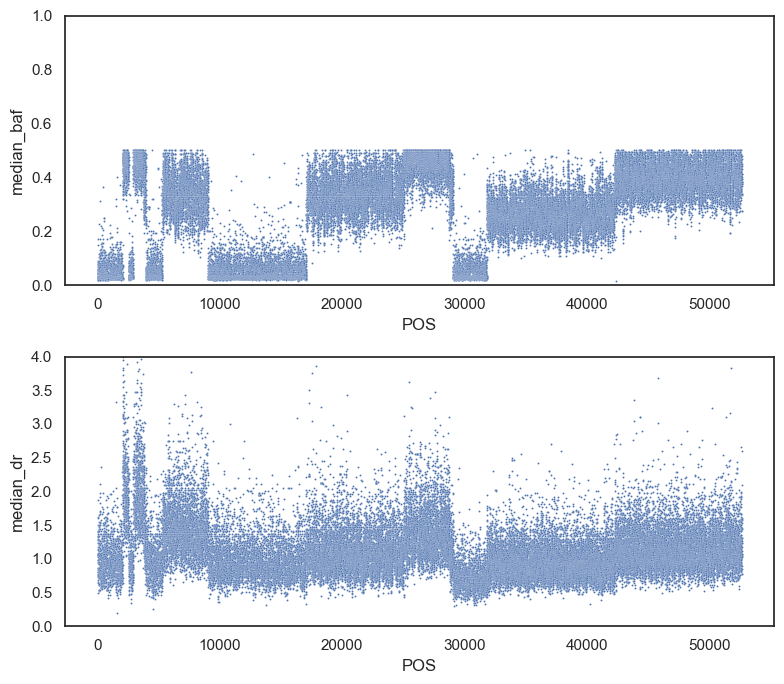

In [3]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(2, 1, figsize=(8, 7))

baf = sns.scatterplot(data=data, x="POS", y="median_baf", s=2, ax=axes[0]), #hue="CN")
dr = sns.scatterplot(data=data, x="POS", y="median_dr", s=2, ax=axes[1])#, hue="CN", legend=False)

axes[0].set_ylim(0,1)
axes[1].set_ylim(0,4) 

fig.tight_layout()

In [3]:
data_input = {'baf':torch.tensor(np.array(data.median_baf).reshape(-1, 1)), 
            'dr':torch.tensor(np.array(data.median_dr).reshape(-1, 1)),
            'dp_snp':torch.tensor(np.array(data.DP).reshape(-1, 1))}

In [5]:
import locate.locate as l
from locate.models import Clonal
from locate.utils import plot_loss
#from locate.utils import plot_results_simulations

In [6]:
locate = l.LOCATE(CUDA = False)

locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf": data_input["baf"],
                         "dr": data_input["dr"], 
                         "dp_snp": data_input["dp_snp"], 
                         "vaf": None, 
                         "dp": None
                         })

locate.set_model_params({"jumping_prob" : 1e-6,
                         "fix_purity": False,
                         "prior_purity": 0.99,
                         "prior_ploidy": 2,
                         "scaling_factors": [1,1,1],
                         "prior_bp": False,
                         'init_probs': torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1])
                         })

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [7]:
ll = locate.run(steps = 400, param_optimizer = {"lr" : 0.05})

/Users/lucreziavaleriani/Documents/GitHub/locate/src/locate/models/Clonal.py:183: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((1 - self._params["jumping_prob"]) * torch.eye(5) + self._params["jumping_prob"])
/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
ELBO: -5940.765706512  :   0%|          | 0/400 [00:00<?, ?it/s]/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_E


Done!


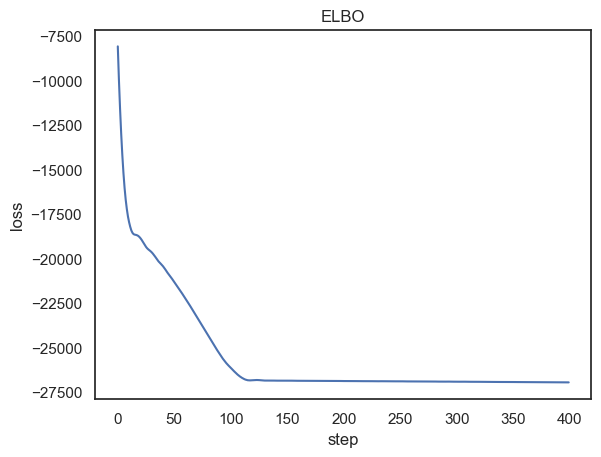

In [9]:
plot_loss(ll[0])

In [10]:
params = locate.learned_parameters_Clonal()

In [11]:
params['purity']

array(0.854271, dtype=float32)

In [12]:
res = pd.DataFrame({'CN_Major':params["CN_Major"]+0.05,
                    'CN_minor':params["CN_minor"]-0.05,
                    'pos':[i for i in range(len(params["CN_minor"]))]})

In [13]:
data

,pos,median_baf,median_dr,DP,original_baf,POS
0,1,0.150000,0.806723,20,0.850000,0
2,53,0.073171,1.171429,41,0.926829,2
3,54,0.047619,1.066667,42,0.952381,3
4,56,0.023256,1.228571,43,0.976744,4
5,58,0.020833,1.496104,48,0.979167,5
...,...,...,...,...,...,...
52651,21876,0.467532,1.583059,77,0.467532,52651
52652,21877,0.448718,1.026316,78,0.551282,52652
52653,21878,0.383721,1.229977,86,0.383721,52653
52654,21879,0.411765,1.270933,85,0.588235,52654


In [14]:
res_tosave = pd.DataFrame({'CN_Major':params["CN_Major"]+0.05,
                           'CN_minor':params["CN_minor"]-0.05,
                            'baf':data.median_baf,
                            'dr':data.median_dr,
                            'or_baf':data.original_baf,
                            'pos':[i for i in range(len(params["CN_minor"]))],
                            })
res_tosave.to_csv('~/Desktop/PDO61_res.csv', header=True)

In [15]:
len(params["CN_Major"])

47001

In [16]:
len(data.median_baf)

47001

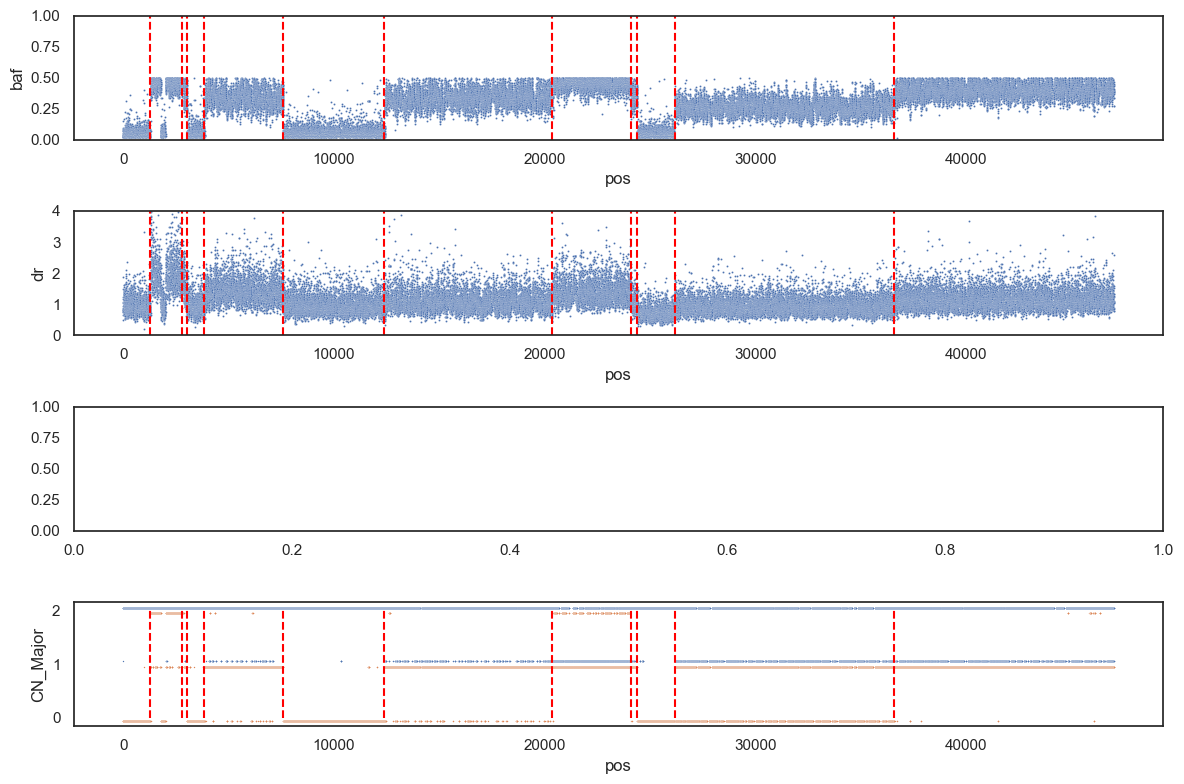

In [19]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(4, 1, figsize=(12, 8))

baf = sns.scatterplot(data=res_tosave, x="pos", y="baf", s=2, ax=axes[0])#, hue="CN")
dr = sns.scatterplot(data=res_tosave, x="pos", y="dr", s=2, ax=axes[1])#, hue="CN", legend=False)
#vaf = sns.scatterplot(data=data, x="pos", y="gt_AF", s=2, ax=axes[2], hue="CN", legend=False)
dr.vlines(x = bp, ymin = 0, ymax = 4,linestyles = ["dashed"], colors = ["red"])
baf.vlines(x = bp, ymin = 0, ymax = 1,linestyles = ["dashed"], colors = ["red"])

cn = sns.scatterplot(data=res_tosave, x="pos", y="CN_Major", s=1, ax=axes[3], legend=False)
cn = sns.scatterplot(data=res_tosave, x="pos", y="CN_minor", s=1, ax=axes[3], legend=False)
cn.vlines(x = bp, ymin = 0, ymax = 2,linestyles = ["dashed"], colors = ["red"])

axes[0].set_ylim(0,1) 
axes[1].set_ylim(0,4) 
axes[2].set_ylim(0,1) 

# sns.move_legend(
#     baf, 
#     "lower center",
#     bbox_to_anchor=(.5, 1.2), ncol=4, title=None, frameon=True,
#     prop={'size': 12},
#     markerscale=5 
# )

fig.tight_layout()

In [18]:
bp = [1253, 2791, 3041, 3846, 7598, 12383, 20360, 24073, 24374, 26159, 36568]